In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score
warnings.simplefilter(action="ignore", category=FutureWarning)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-disease-dataset/heart.csv


In [2]:
raw_data=pd.read_csv('/kaggle/input/heart-disease-dataset/heart.csv')

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
raw_data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [5]:
raw_data.describe().style.background_gradient(cmap='Reds')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
raw_data.corr().style.background_gradient(cmap='Reds')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


In [7]:
raw_data.drop_duplicates()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [8]:
def plotting(data):
    for column in data.columns:
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        data[column].plot(kind='hist')
        plt.title(f'{column} histogram')
        
        plt.subplot(1,3,2)
        sns.histplot(data[column],kde=True,stat='density',linewidth=0)
        plt.title(f'{column} distribution')
        
        plt.subplot(1,3,3)
        sns.boxplot(data[column])
        plt.title(f'{column} box plot')
        plt.tight_layout()
        plt.show()

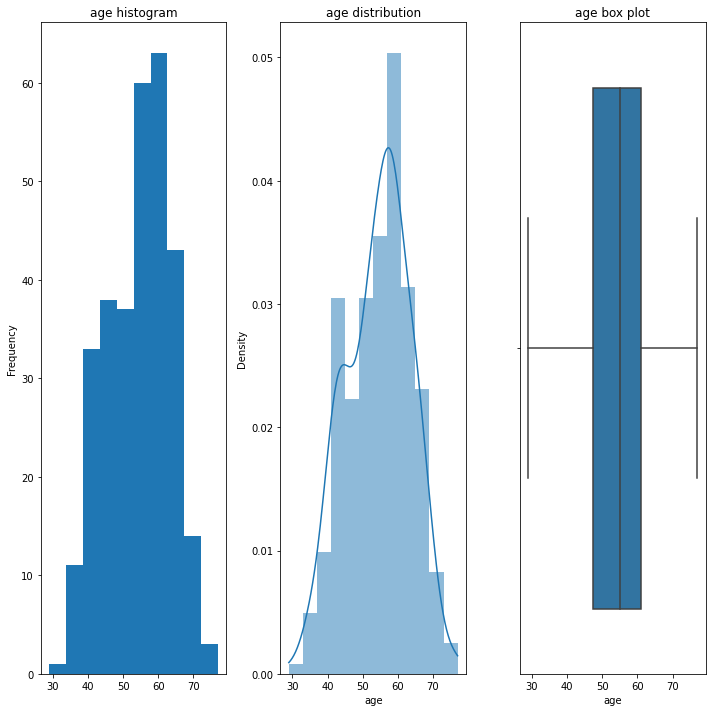

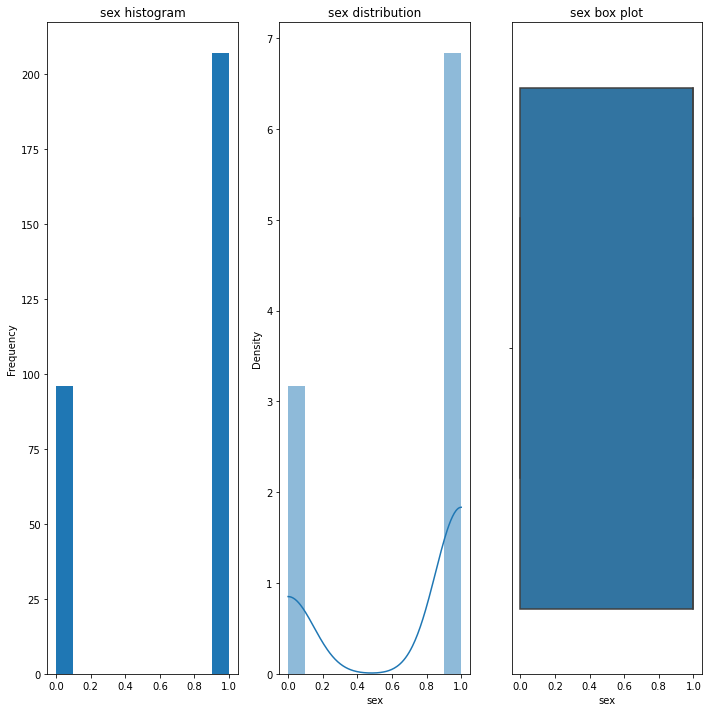

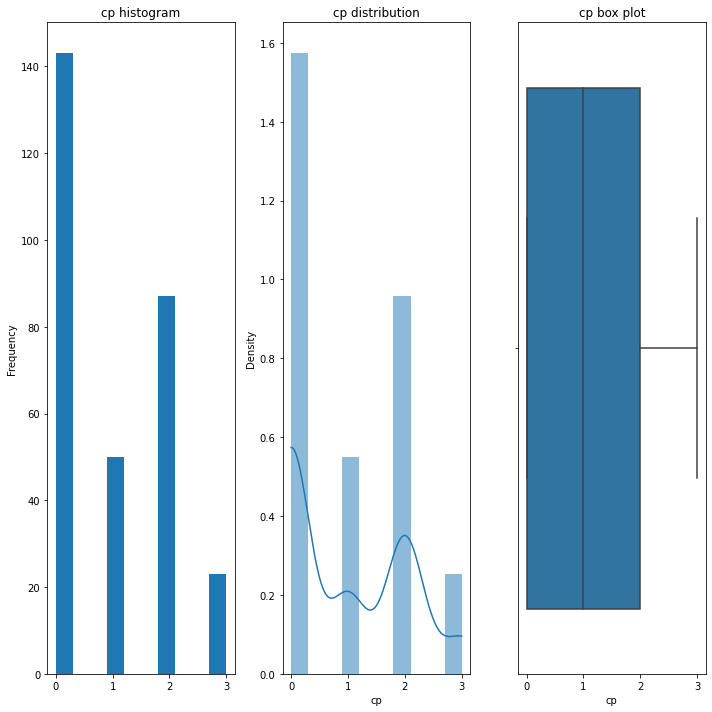

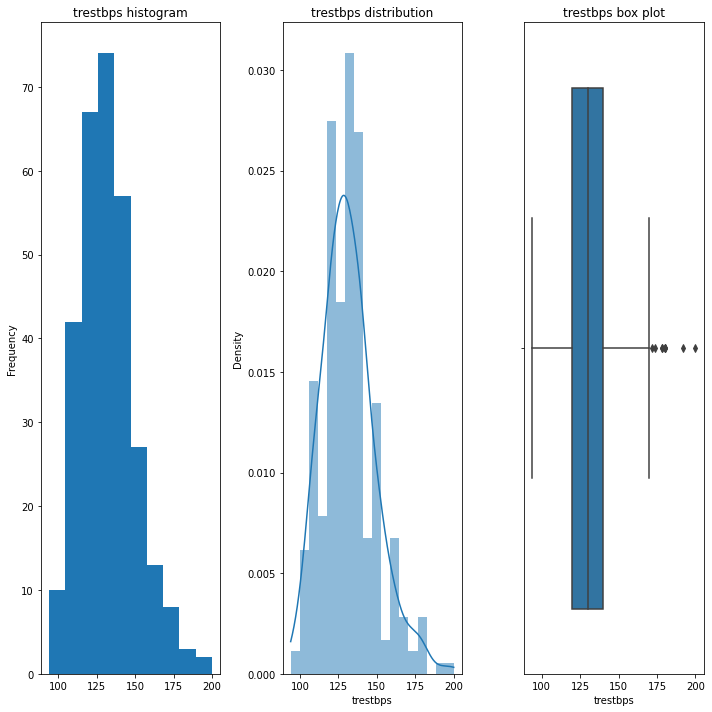

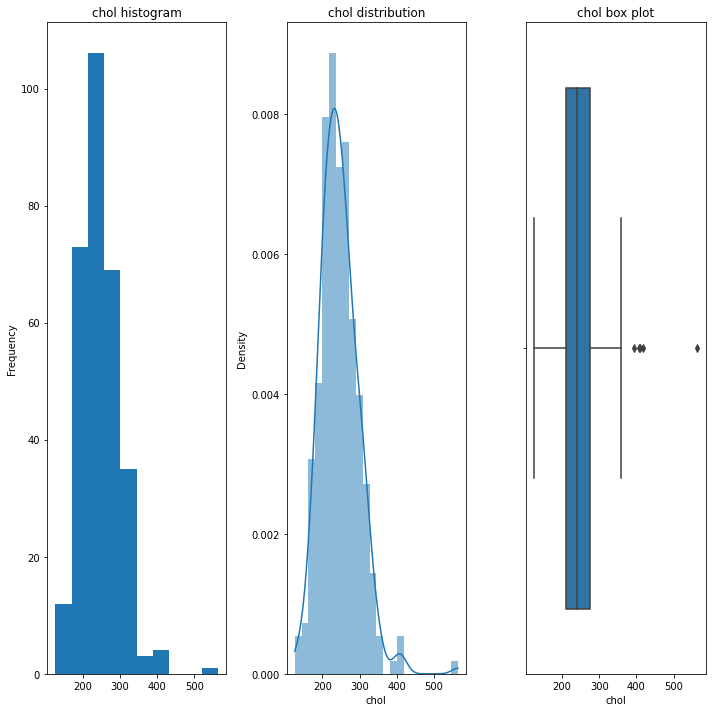

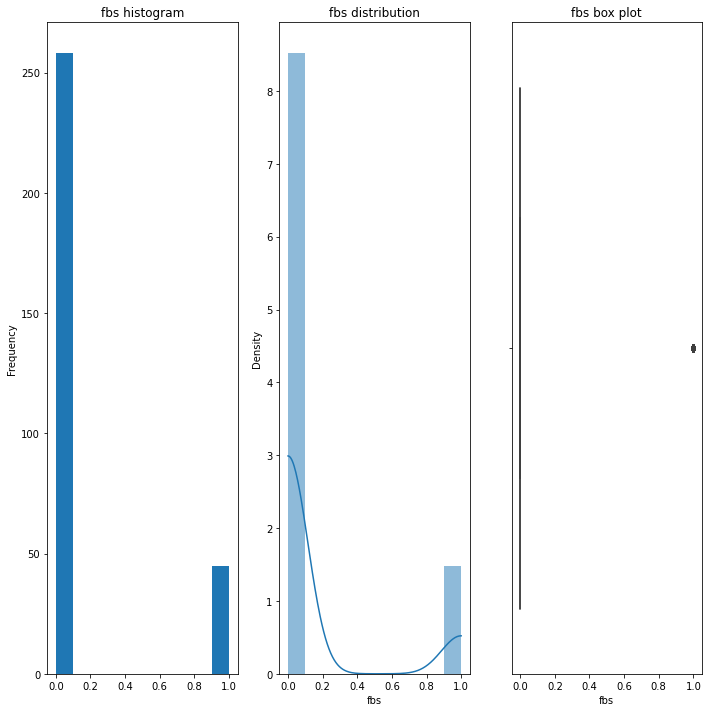

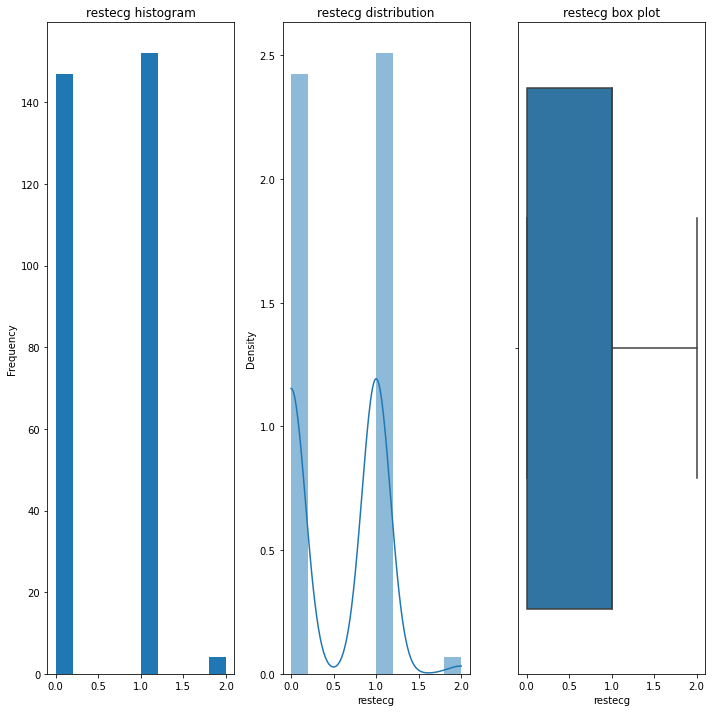

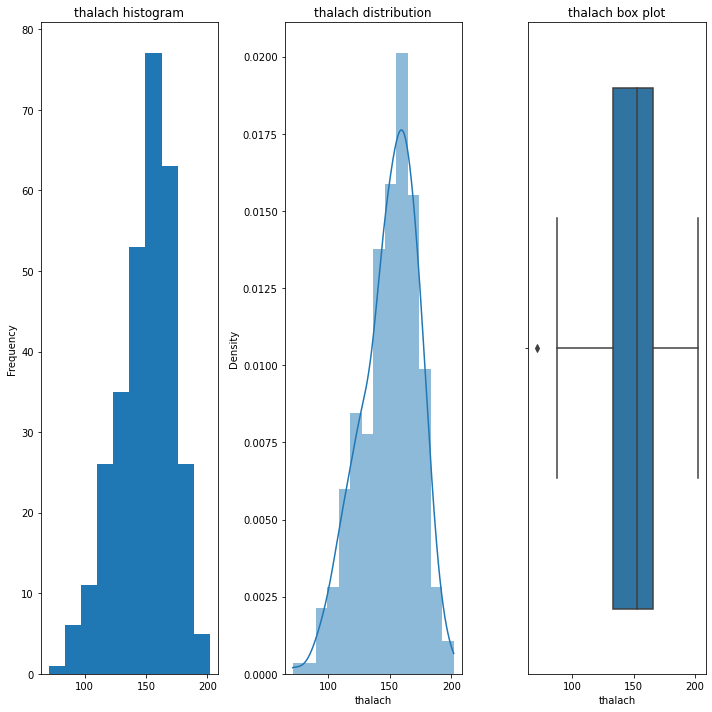

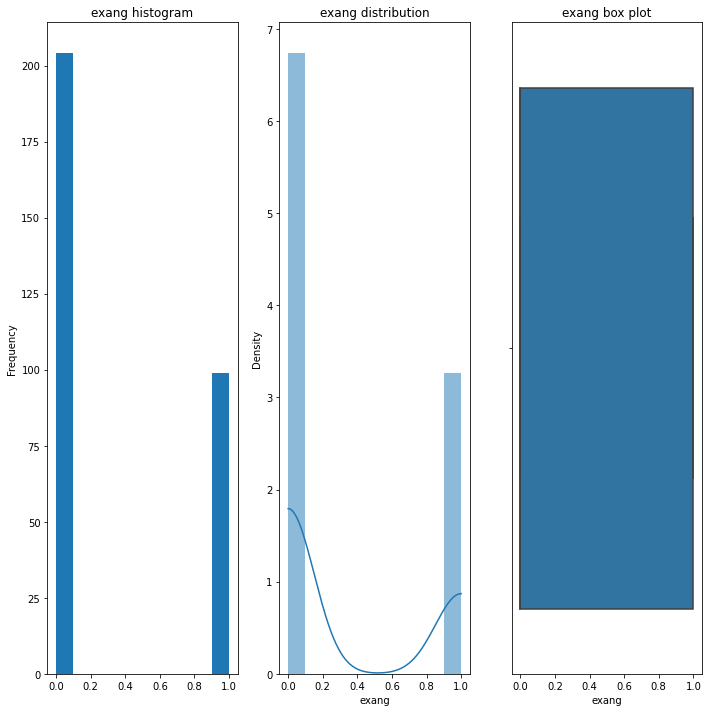

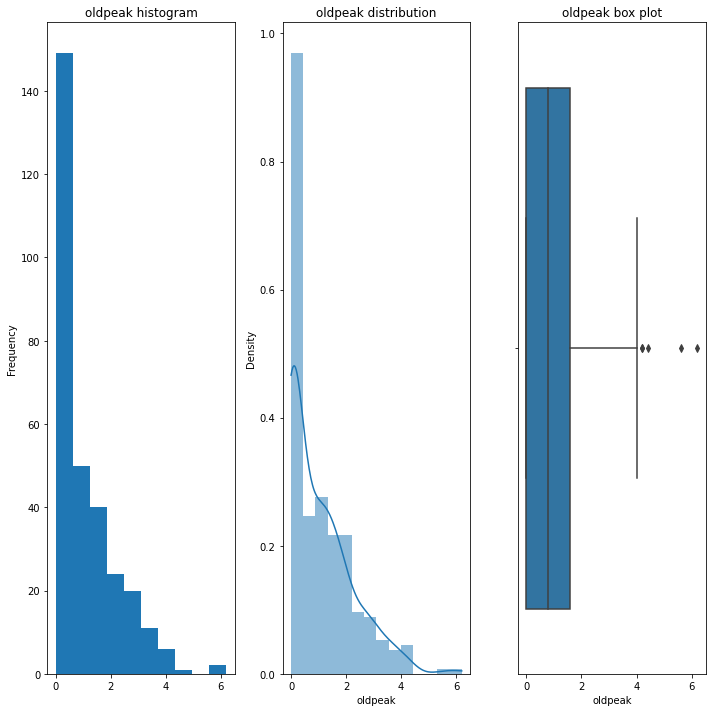

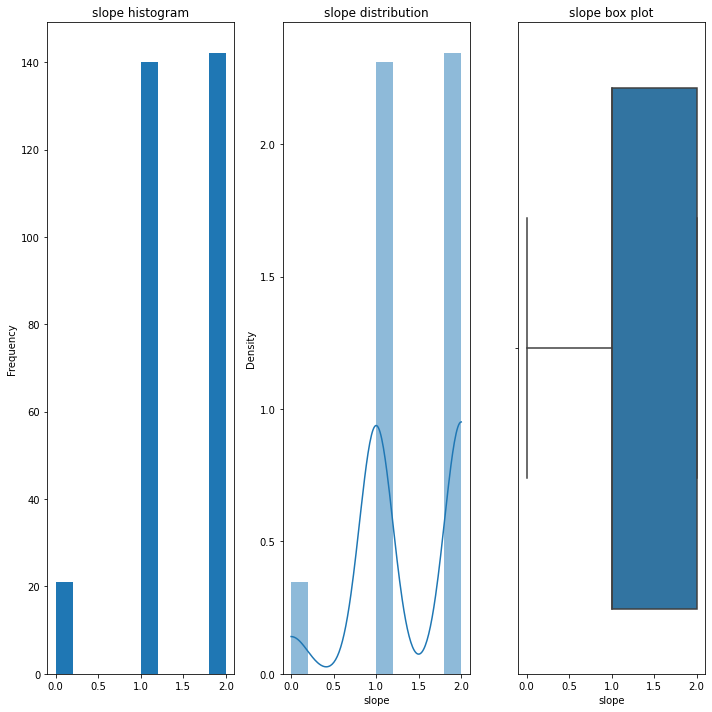

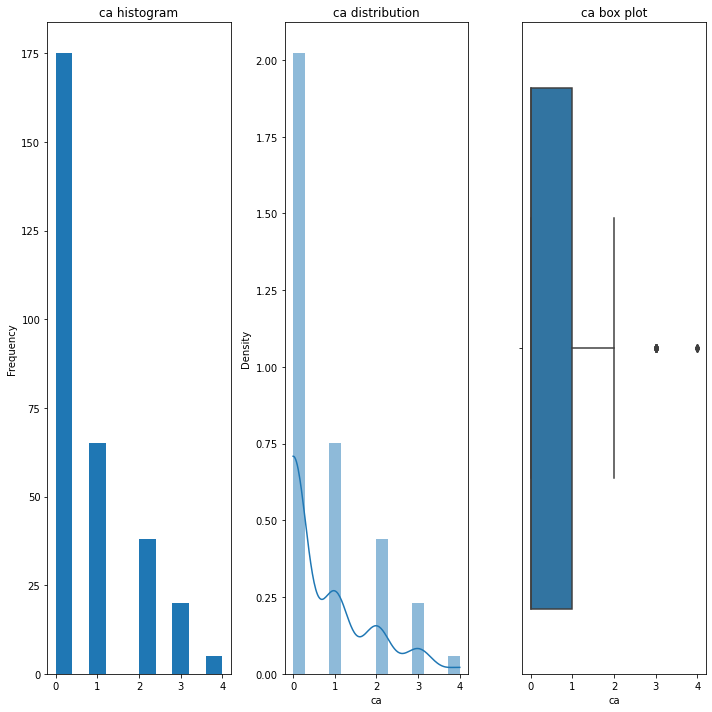

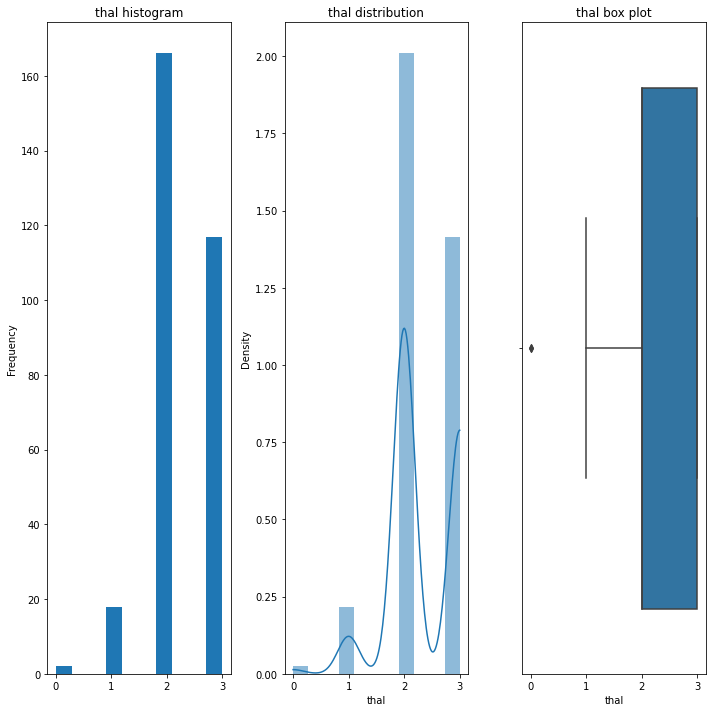

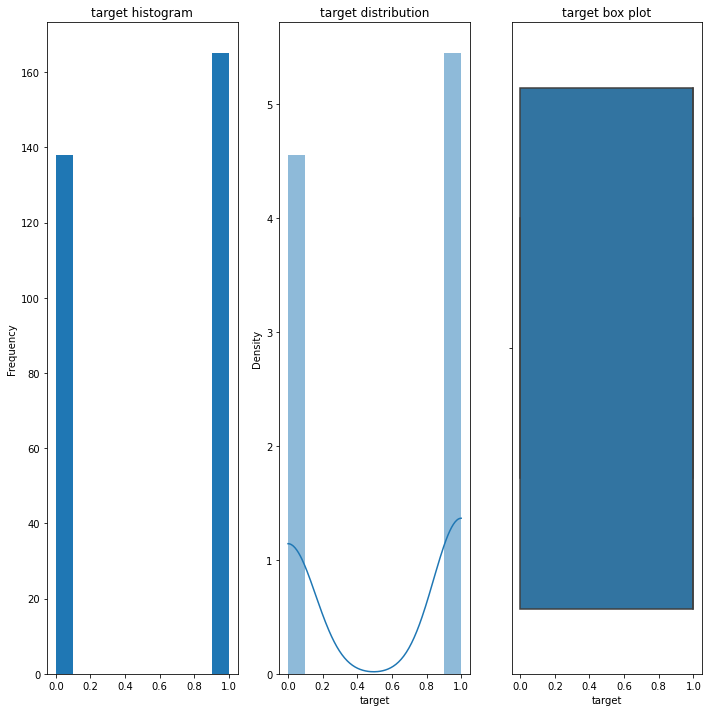

In [9]:
plotting(raw_data)

In [10]:
def make_score_MI(X,y,discrete_features):
    mi_scores=mutual_info_classif(X,y,discrete_features=discrete_features)
    ser_mi_scores=pd.Series(mi_scores,index=X.columns,name='MI_scores')
    ser_mi_scores=ser_mi_scores.sort_values(ascending=False)
    return ser_mi_scores

In [11]:
discrete_features = raw_data.drop(['target'],axis=1).dtypes == int
y_1=raw_data['target']
X_1=raw_data[discrete_features.index]
mi_scores=make_score_MI(X_1,y_1,discrete_features)
print(mi_scores)

chol        0.387980
thalach     0.232272
thal        0.147814
cp          0.141817
ca          0.128896
exang       0.098573
trestbps    0.097337
age         0.093786
slope       0.080983
oldpeak     0.079975
sex         0.040992
restecg     0.016687
fbs         0.000392
Name: MI_scores, dtype: float64


In [12]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


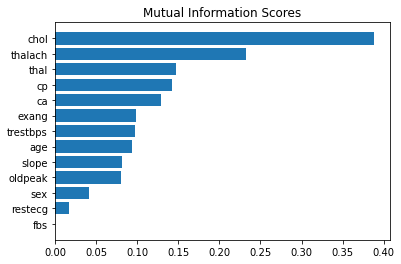

In [13]:
plot_mi_scores(mi_scores)

[Text(0, 0, 'Risk of HD'), Text(1, 0, 'No risk')]

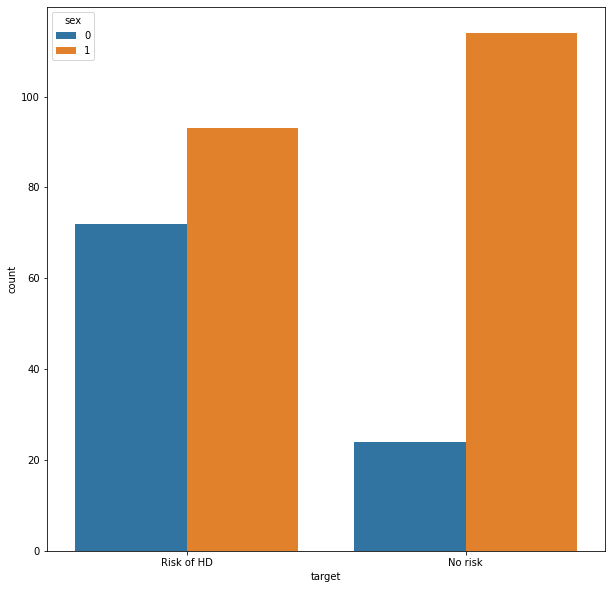

In [14]:

plt.figure(figsize=(10,10))
ax=sns.countplot(x='target',data=raw_data,hue='sex',order = [1,0])
ax.set_xticklabels(['Risk of HD','No risk'])

In [15]:
print('{} % man'.format(raw_data['sex'][raw_data['sex']==1].count()*100/raw_data['sex'].count()))
print('{} % woman'.format(raw_data['sex'][raw_data['sex']==0].count()*100/raw_data['sex'].count()))

68.31683168316832 % man
31.683168316831683 % woman


<Figure size 720x720 with 0 Axes>

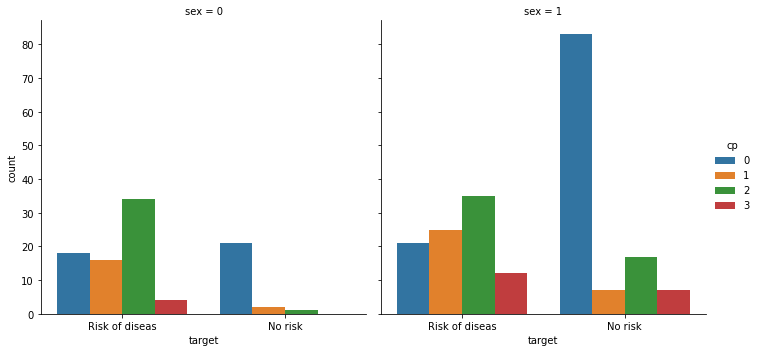

<Figure size 720x720 with 0 Axes>

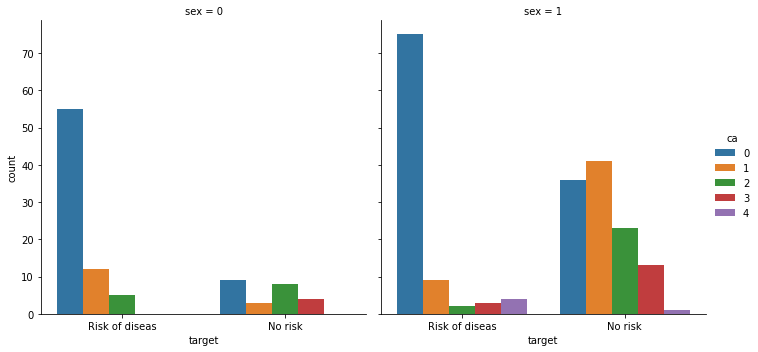

In [16]:
for column in ['cp','ca']:
    plt.figure(figsize=(10,10))
    ax=sns.catplot(x='target',data=raw_data,hue=column,col='sex',kind='count',order=[1,0])
    ax.set_xticklabels(['Risk of diseas','No risk'])

In [17]:
print('men-{}'.format(raw_data['chol'][raw_data['sex']==1].mean()))
print('women-{}'.format(raw_data['chol'][raw_data['sex']==0].mean()))

men-239.28985507246378
women-261.3020833333333


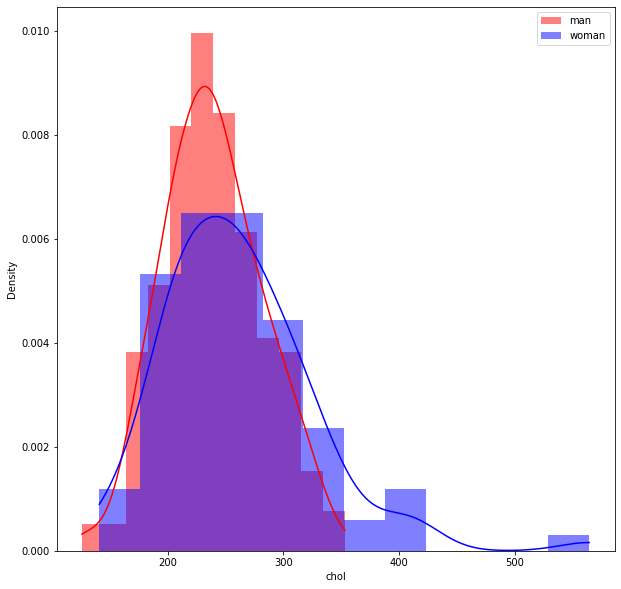

In [18]:
plt.figure(figsize=(10,10))
sns.histplot(raw_data['chol'][raw_data['sex']==1],kde=True,stat='density',linewidth=0,label='man',color='red')
sns.histplot(raw_data['chol'][raw_data['sex']==0],kde=True,stat='density',linewidth=0,label='woman',color='blue')
plt.legend()

<Figure size 720x720 with 0 Axes>

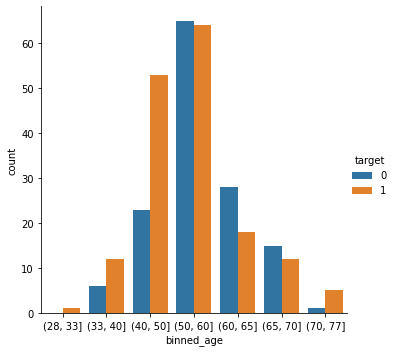

In [19]:
plt.figure(figsize=(10,10))
bins = [28,33,40,50,60,65,70,77]
raw_data["binned_age"] = pd.cut(raw_data['age'], bins)
ax=sns.catplot(x='binned_age',data=raw_data,hue='target',kind='count')

<AxesSubplot:xlabel='thalach', ylabel='thal'>

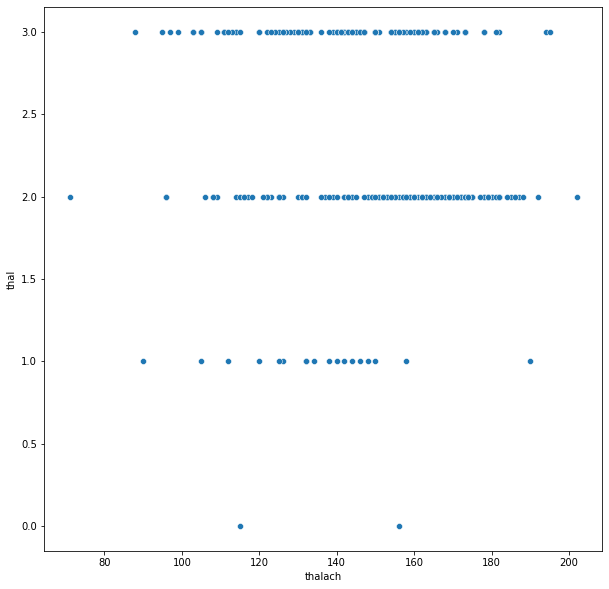

In [20]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=raw_data,x='thalach',y='thal')

In [21]:
features=mi_scores[mi_scores>0.1].index.tolist()
X=raw_data[features]
y=raw_data['target']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,train_size=0.8,test_size=0.2)

AUC SVC(kernel='linear', probability=True): 0.863
AUC RandomForestClassifier(random_state=42): 0.892
AUC LogisticRegression(): 0.867


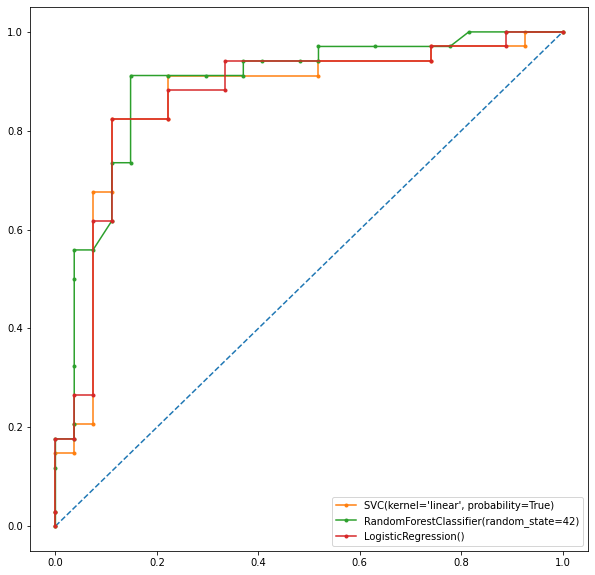

In [22]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
for model in [SVC(kernel='linear',probability=True),RandomForestClassifier(random_state=42),LogisticRegression()]:
    model.fit(X_train,y_train)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    auc = roc_auc_score(y_test, probs)
    print(f'AUC {model}: %.3f' % auc)
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, marker='.',label=f'{model}')
plt.legend()
plt.show()

In [23]:
model_1=RandomForestClassifier(random_state=42)
param_grid_1 = { 
    'max_leaf_nodes': [10,12,15,17,20],
    'n_estimators': [100,200,250,300,400,500]}
CV_1=GridSearchCV(model_1,param_grid_1,n_jobs=4,cv=5,scoring=('precision'))
CV_1.fit(X_train,y_train)
print(f'val_precision-{CV_1.best_score_}')
model_end_1=RandomForestClassifier(max_leaf_nodes=CV_1.best_params_['max_leaf_nodes'],n_estimators=CV_1.best_params_['n_estimators'],random_state=42)
model_end_1.fit(X_train,y_train)
y_pred_1=model_end_1.predict(X_test)
print(f'test precision - {precision_score(y_test,y_pred_1)}')

val_precision-0.8068348989719956
test precision - 0.8787878787878788


In [24]:
model_2=LogisticRegression(random_state=42)
param_grid_2 = {'tol':[1e-3,1e-4,1e-2],
                'C':[0.8,0.9,1]}
CV_2=GridSearchCV(model_2,param_grid_2,n_jobs=4,cv=5,scoring=('precision'))
CV_2.fit(X_train,y_train)
print(f'val_precision-{CV_1.best_score_}')
model_end_2=LogisticRegression(tol=CV_2.best_params_['tol'],C=CV_2.best_params_['C'])
model_end_2.fit(X_train,y_train)
y_pred_2=model_end_2.predict(X_test)
print(f'test precision - {precision_score(y_test,y_pred_2)}')

val_precision-0.8068348989719956
test precision - 0.8484848484848485
